In [53]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import subprocess


data_dir = 'prep_result/summit'


In [ ]:
# copy labels from cluster
# Define the source and destination for scp
source = 'jmccabe@localhost:/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/*_label.npy'
destination = data_dir

# Use subprocess to run the scp command
scp_command = ['scp', "-P", "2222", source, destination]
subprocess.run(scp_command, check=True)

# combine into a single labels file

combined_results = {}
for label_path in tqdm(Path(data_dir).rglob('*_label.npy')):
    label = np.load(label_path)
    if label.shape[0] != 1:
        for i, l in enumerate(label):
            combined_results[label_path.stem.replace('_label','') + '_' + str(i)] = l

In [113]:
# convert to dataframe and save
combined_df = pd.DataFrame.from_dict(combined_results, orient='index')
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'id'}, inplace=True)
display(combined_df.head())
combined_df.to_csv('prep_result/summit/labels.csv', index=False)

In [170]:
import SimpleITK as sitk
from matplotlib import pyplot as plt
import os

workspace = Path(os.getcwd()).parent.parent

def copy_scan_from_cluster(scan_id, workspace):
    study_id = scan_id.split('_')[0]
   # now copy the src file
    if not os.path.exists(f"{workspace}/data/summit/scans/{study_id}/{scan_id}.mhd"):
        os.makedirs(f"{workspace}/data/summit/scans/{study_id}", exist_ok=True)

        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SummitLung50/{study_id}/{scan_id}.*",
            f"{workspace}/data/summit/scans/{study_id}/."
        ]
        result = subprocess.run(command)
        print(result.stdout)
    else:
        print(f'{scan_id} already exists')

def read_mhd(file_path):
    itk_image = sitk.ReadImage(file_path)
    scan = sitk.GetArrayFromImage(itk_image)
    return scan, itk_image.GetSpacing(), itk_image.GetDirection(), itk_image.GetOrigin()

def show_nodule(scan_id, x, y, z, d, workspace):
    scan, spacing, orientation, origin = read_mhd(f"{workspace}/data/summit/scans/{scan_id.split('_')[0]}/{scan_id}.mhd")

    print(spacing)

    # Convert x, y, z to row, col, index
    row = int((x - origin[0]) / spacing[0])
    col = int((y - origin[1]) / spacing[1])
    idx = int((z - origin[2]) / spacing[2])

    print(f'{scan_id} - x: {x}, y: {y}, z: {z}, d: {d} / row: {row}, col: {col}, idx: {idx}, scan shape: {scan.shape}')
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(scan[idx,:,:], cmap='gray')
    circle = plt.Circle((row, col), d, color='r', fill=False)
    ax.add_artist(circle)
    plt.show()


In [167]:
# Check if any labels have negative values

labels = (
    pd.read_csv('prep_result/summit/labels.csv', index_col=0)
    .rename(columns={'0': 'idx', '1': 'row', '2': 'col', '3': 'd'})
    .assign(scan_id=lambda df: df.index.str.rsplit('_', 1).str[0])
    .reset_index()
    .drop(columns='id')
)

metadata = (
    pd.concat([
        pd.read_csv(f'{workspace}/metadata/summit/optimisation/{ds}_metadata.csv', usecols=['scan_id','nodule_x_coordinate', 'nodule_y_coordinate', 'nodule_z_coordinate', 'nodule_diameter_mm'])
        for ds in ['training', 'validation', 'test', 'holdout']
    ])
)

shapes = (
    pd.read_csv('prep_result/summit/shapes.csv')
    .rename(columns={'id' : 'scan_id', '0': 'c_dim', '1': 'idx_dim', '2': 'row_dim', '3': 'col_dim'})
)

qc_data = (
    pd.merge(labels, shapes, on='scan_id')
    .assign(row_diff=lambda df: df.row - df.row_dim)
    .assign(col_diff=lambda df: df.col - df.col_dim)
    .assign(idx_diff=lambda df: df.idx - df.idx_dim)
)

nodules_outside_scan_dims = qc_data.query('row_diff > 0 | col_diff > 0 | idx_diff > 0')

negative_labels = qc_data.query('row < 0 | col < 0 | idx < 0 | d < 0')

display(metadata.head(5))
display(nodules_outside_scan_dims)
display(negative_labels)

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/ipykernel_24320/2108297765.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  .assign(scan_id=lambda df: df.index.str.rsplit('_', 1).str[0])


,nodule_diameter_mm,nodule_x_coordinate,nodule_y_coordinate,nodule_z_coordinate,scan_id
0,7.6,73.05,56.84,-190.33,summit-2222-djr_Y0_BASELINE_A
1,10.0,58.76,61.71,-187.04,summit-2222-djr_Y0_BASELINE_A
2,4.8,-92.18,-51.99,-230.21,summit-2222-djr_Y0_BASELINE_A
3,6.1,57.64,2.88,-178.43,summit-2225-stn_Y0_BASELINE_A
4,3.7,-81.66,-72.17,-186.41,summit-2225-stn_Y0_BASELINE_A


,idx,row,col,d,scan_id,c_dim,idx_dim,row_dim,col_dim,row_diff,col_diff,idx_diff
229,76.020,128.92,167.689997,1.695312,summit-9754-pkv_Y0_BASELINE_A,1,219,177,121,-48.08,46.689997,-142.980
6521,104.615,79.99,232.570003,3.575002,summit-8935-guu_Y0_BASELINE_A,1,218,179,136,-99.01,96.570003,-113.385
7749,166.375,248.35,215.540000,11.742192,summit-3399-wdd_Y0_BASELINE_A,1,237,209,288,39.35,-72.460000,-70.625


,idx,row,col,d,scan_id,c_dim,idx_dim,row_dim,col_dim,row_diff,col_diff,idx_diff
6289,-62.970,47.73,48.730000,4.531248,summit-6597-erv_Y0_BASELINE_A,1,145,207,247,-159.27,-198.270000,-207.970
6290,-61.900,29.61,40.550000,1.642577,summit-6597-erv_Y0_BASELINE_A,1,145,207,247,-177.39,-206.450000,-206.900
6291,-59.710,39.29,57.320000,2.945311,summit-6597-erv_Y0_BASELINE_A,1,145,207,247,-167.71,-189.680000,-204.710
6292,-54.270,58.47,54.400000,10.648433,summit-6597-erv_Y0_BASELINE_A,1,145,207,247,-148.53,-192.600000,-199.270
6293,-78.600,39.15,11.880000,6.626950,summit-6597-erv_Y0_BASELINE_A,1,145,207,247,-167.85,-235.120000,-223.600
6967,-29.225,82.11,260.160003,3.456253,summit-6344-jbm_Y0_BASELINE_A,1,92,209,273,-126.89,-12.839997,-121.225


summit-9754-pkv_Y0_BASELINE_A not found in metadata
summit-8935-guu_Y0_BASELINE_A not found in metadata
summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: 76.65, y: 22.31, z: -119.74, d: 4.8 / row: 385, col: 290, idx: 211, scan shape: (420, 512, 512)


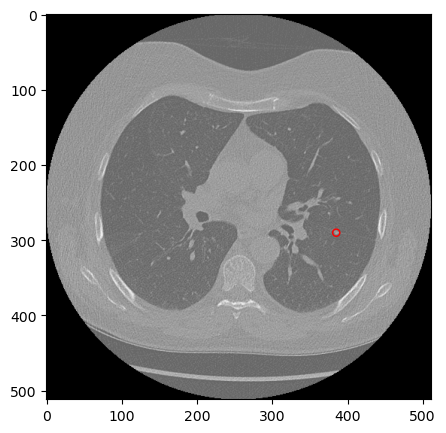

summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: -52.11, y: 48.76, z: -28.95, d: 4.6 / row: 188, col: 330, idx: 356, scan shape: (420, 512, 512)


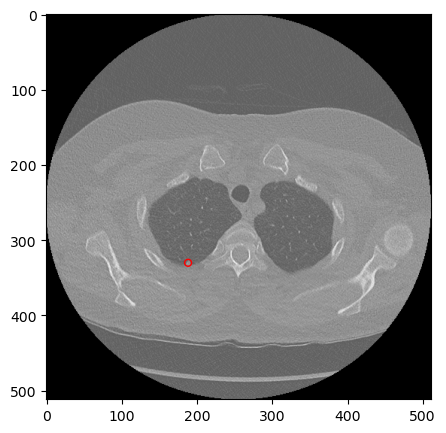

summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: 66.54, y: 145.35, z: -69.5, d: 18.0 / row: 370, col: 478, idx: 291, scan shape: (420, 512, 512)


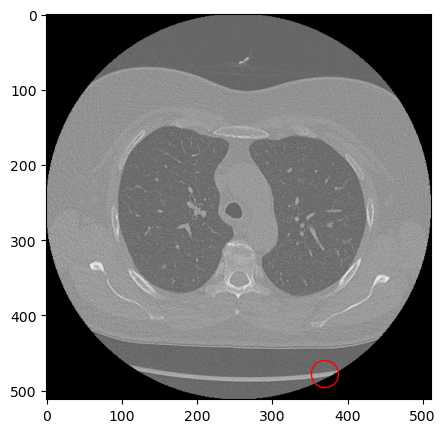

In [171]:

for scan_id in nodules_outside_scan_dims.scan_id.unique():

    md = metadata.query(f'scan_id == "{scan_id}"')
    
    if md.empty:
        print(f'{scan_id} not found in metadata')
        continue

    for i, row in md.iterrows():
    
        copy_scan_from_cluster(scan_id, workspace)
        show_nodule(scan_id, row['nodule_x_coordinate'], row['nodule_y_coordinate'], row['nodule_z_coordinate'], row['nodule_diameter_mm'], workspace)


summit-6597-erv_Y0_BASELINE_A
summit-6597-erv_Y0_BASELINE_A already exists
(145, 207, 247)


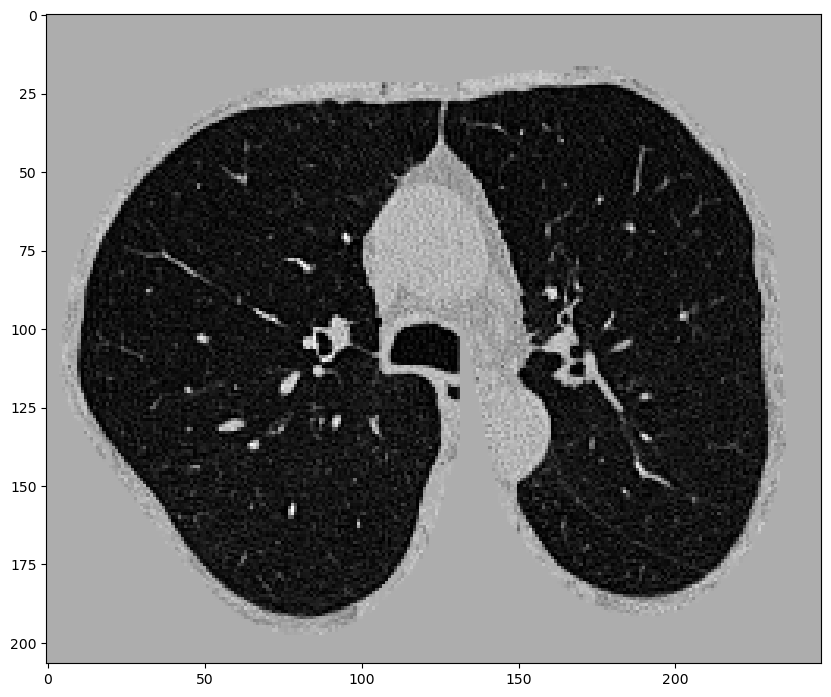

summit-6344-jbm_Y0_BASELINE_A
summit-6344-jbm_Y0_BASELINE_A already exists
(92, 209, 273)


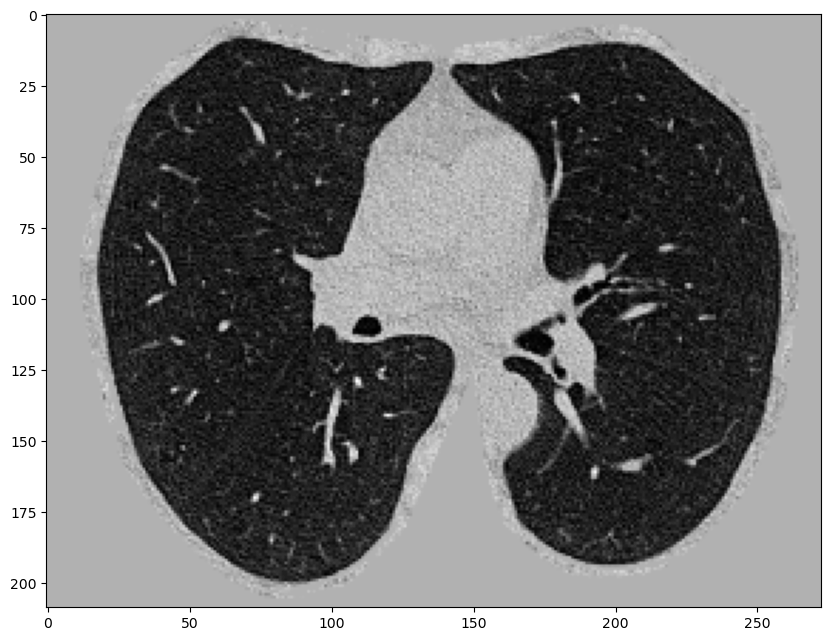

summit-9754-pkv_Y0_BASELINE_A
summit-9754-pkv_Y0_BASELINE_A already exists
(219, 177, 121)


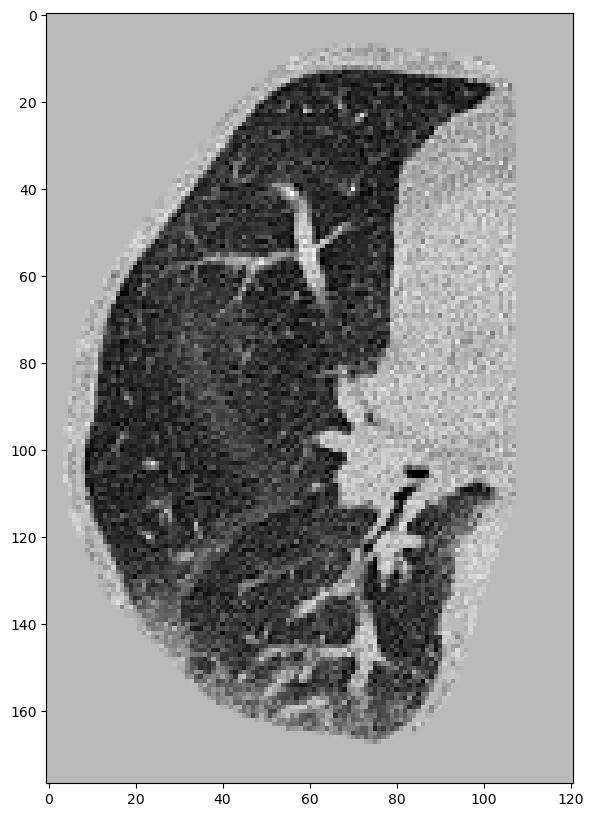

summit-8935-guu_Y0_BASELINE_A
summit-8935-guu_Y0_BASELINE_A already exists
(218, 179, 136)


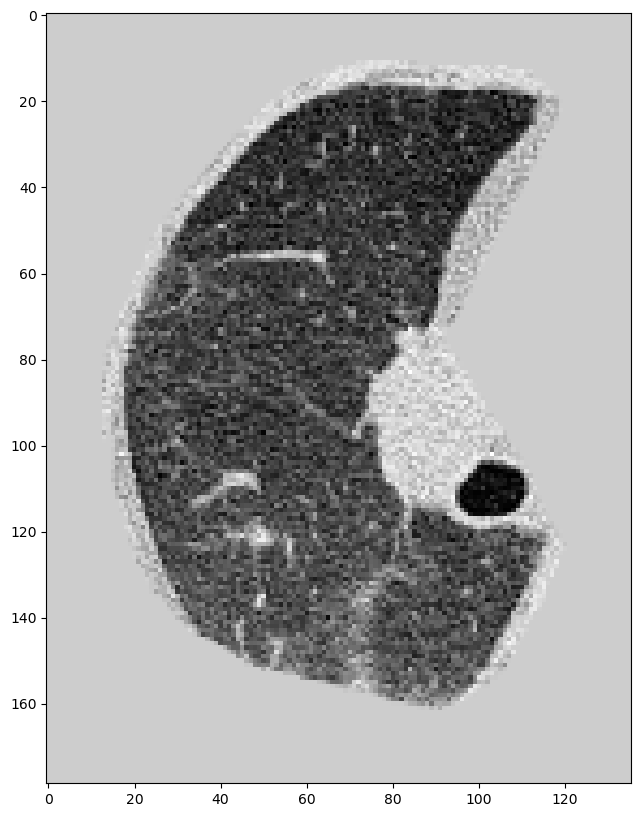

summit-3399-wdd_Y0_BASELINE_A
summit-3399-wdd_Y0_BASELINE_A already exists
(237, 209, 288)


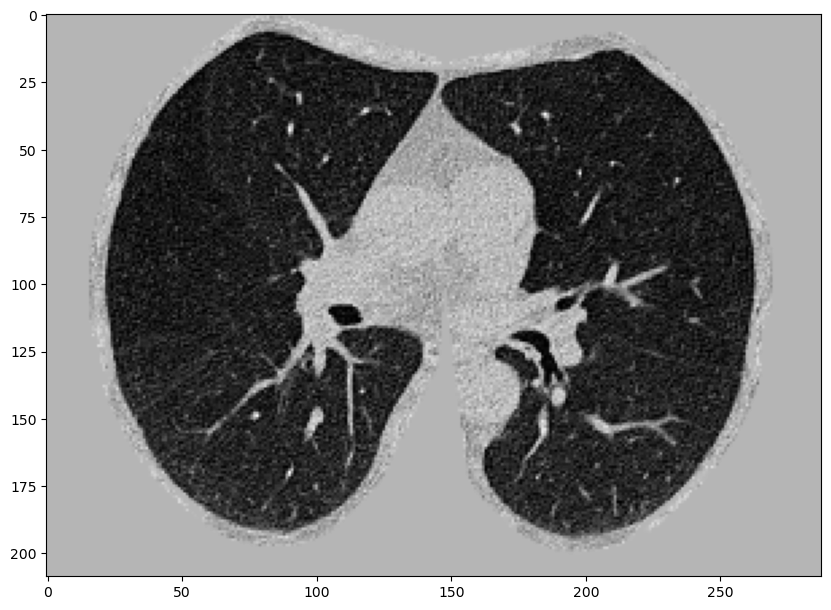

In [169]:
def copy_npy_from_cluster(scan_id, workspace):
    
    if not Path(f"{workspace}/models/grt123/prep_result/summit/{scan_id}_clean.npy").exists():
    
        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/{scan_id}_clean.npy",
            f"{workspace}/models/grt123/prep_result/summit/."
        ]
        result = subprocess.run(command)
        print(result.stdout)

    if not Path(f"{workspace}/models/grt123/prep_result/summit/{scan_id}_label.npy").exists():
        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SUMMIT/cache/sota/grt123/prep_result/summit/{scan_id}_label.npy",
            f"{workspace}/models/grt123/prep_result/summit/."
        ]
        result = subprocess.run(command)
        print(result.stdout)

for scan_id in list(negative_labels.scan_id.unique()) + list(nodules_outside_scan_dims.scan_id.unique()):

    print(scan_id)
    copy_npy_from_cluster(scan_id, workspace)
    copy_scan_from_cluster(scan_id, workspace)
    clean = np.load(f'prep_result/summit/{scan_id}_clean.npy')
    label = np.load(f'prep_result/summit/{scan_id}_label.npy')

    print(clean.squeeze().shape)
    mid_idx = clean.squeeze().shape[0] // 2
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(clean.squeeze()[mid_idx, :, :], cmap='gray')
    plt.show()